In [1]:
# Copied from problem statement

import numpy as np
import csv

rows = []

with open('WHOI-ML/Section 2/Part 2/Fish.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        rows.append(row)

print(len(rows))
print(rows[0]) # first row is a header
print(rows[1])

rows = rows[1:]

labels = {} # Create a dictionary of label strings to numeric values
for row in rows:
    if row[0] not in labels:
        labels[row[0]]=len(labels)

print(labels)
        
inputs = np.array([row[1:] for row in rows]).astype(np.float32)
outputs = np.array([labels[row[0]] for row in rows])
print(outputs)

160
['\ufeffSpecies', 'Weight', 'Length1', 'Length2', 'Length3', 'Height', 'Width']
['Bream', '242', '23.2', '25.4', '30', '11.52', '4.02']
{'Bream': 0, 'Roach': 1, 'Whitefish': 2, 'Parkki': 3, 'Perch': 4, 'Pike': 5, 'Smelt': 6}
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6
 6 6 6 6 6 6 6 6 6 6 6]


In [2]:
def output_to_one_hot(categories, max_val):
    data = np.zeros((len(categories), max_val))
    data[np.arange(len(categories)), categories] = 1
    return data

encodings = output_to_one_hot(outputs, len(labels))
print(encodings[:10])
print(encodings[-10:])

[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]]


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(inputs, encodings)

In [4]:
from __future__ import print_function
import torch; print(torch.__version__)
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import trange # Used to provide progress bar

%matplotlib inline

def buildSequential(breadth, depth, indim=6, outdim=7):
    layers = []
    
    layers.append(nn.Linear(indim, breadth, bias=True))
    layers.append(nn.ReLU())
    for i in range(0, depth-2):
        layers.append(nn.Linear(breadth, breadth, bias=True))
        layers.append(nn.ReLU())
    layers.append(nn.Linear(breadth, outdim, bias=True))
      
    return nn.Sequential(*layers)

1.1.0


In [5]:
def run_once(inputs, true_vals, net, learning_rate=1, num_epochs=100):
    
    # Initialize
    net.zero_grad()
    outputs = net(Variable(torch.Tensor([0]*inputs.shape[1])))
    outputs.backward(torch.randn(true_vals.shape[1])) # Use random gradients to break symmetry?

    for f in net.parameters():
        f.data.sub_(f.grad.data * learning_rate)

    losses = []

    # create your optimizer
    optimizer = optim.Adam(net.parameters())
    criterion = nn.MSELoss()

    #t = trange(num_epochs)
    #for epoch in t:  # loop over the dataset multiple times
    for epoch in range(0, num_epochs):
        running_loss = 0.0

        # wrap them in Variable
        reshaped_inputs = torch.as_tensor(inputs, dtype=torch.float32) # Structure with each input in its own row
        reshaped_outputs = torch.as_tensor(true_vals, dtype=torch.float32) # Neglecting to have outputs and true vals to match dimension is a common mistake.

        # forward + backward + optimize
        outputs = net(reshaped_inputs)
        #print(outputs)
        #print(reshaped_outputs)
        loss = criterion(outputs, reshaped_outputs)
        losses.append(loss)

        loss.backward()
        optimizer.step()

        # zero the parameter gradients
        optimizer.zero_grad()

        #t.set_description('ML (loss=%g)' % loss.item()) # Updates Loss information
        #t.set_description('ML Loss: ' + str(loss.item())) # Updates Loss information

    print('Finished Training')
    
    predicted =net.forward(reshaped_inputs).data.numpy()
    
    return losses, predicted, net

In [6]:
print(inputs.shape)

(159, 6)


In [7]:
NUM_EPOCHS=10000

breadthdepth = np.array([
    [10,3],
    [20,3],
    [50,3],
    [100,3],
    [10, 4],
    [50, 4],
    [10, 5],
    [20, 5]    
])

train_err = np.zeros((breadthdepth.shape[0],), dtype=np.float)
test_err = np.zeros((breadthdepth.shape[0],), dtype=np.float)
train_success = np.zeros((breadthdepth.shape[0],), dtype=np.float)
test_success = np.zeros((breadthdepth.shape[0],), dtype=np.float)

y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

for i in range(breadthdepth.shape[0]):
    losses, predicted, net = run_once(X_train, y_train, buildSequential(breadth=breadthdepth[i,0], depth=breadthdepth[i,1]), num_epochs=NUM_EPOCHS)

    train_pred = net.forward(torch.from_numpy(X_train)).data.numpy()
    test_pred = net.forward(torch.from_numpy(X_test)).data.numpy()

    train_err[i] = mean_squared_error(train_pred, y_train)
    test_err[i] = mean_squared_error(test_pred, y_test)
    
    train_labels = np.argmax(train_pred, axis=1)
    test_labels = np.argmax(test_pred, axis=1)

    train_success[i] = np.sum(train_labels == y_train_labels) / train_labels.shape[0]
    test_success[i] = np.sum(test_labels == y_test_labels) / test_labels.shape[0]

print('Done!')

    

Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Done!


In [8]:
for i in range(0, breadthdepth.shape[0]):
    print('Breadth: %4d Depth=%4d Train Succes Rate: %10.4f Test Succes Rate: %10.4f' 
          % (breadthdepth[i,0], breadthdepth[i,1],
             train_success[i]*100.0, test_success[i]*100.0))


Breadth:   10 Depth=   3 Train Succes Rate:    36.9748 Test Succes Rate:    32.5000
Breadth:   20 Depth=   3 Train Succes Rate:    78.9916 Test Succes Rate:    82.5000
Breadth:   50 Depth=   3 Train Succes Rate:    98.3193 Test Succes Rate:    92.5000
Breadth:  100 Depth=   3 Train Succes Rate:    91.5966 Test Succes Rate:    87.5000
Breadth:   10 Depth=   4 Train Succes Rate:    66.3866 Test Succes Rate:    72.5000
Breadth:   50 Depth=   4 Train Succes Rate:    93.2773 Test Succes Rate:    90.0000
Breadth:   10 Depth=   5 Train Succes Rate:    73.1092 Test Succes Rate:    65.0000
Breadth:   20 Depth=   5 Train Succes Rate:    95.7983 Test Succes Rate:    92.5000


Finished Training


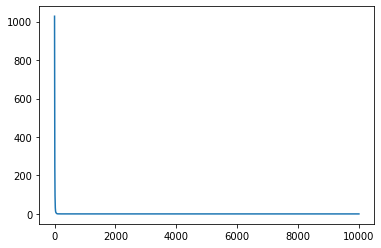

In [9]:
# Re-run for our best result so far, and see what we get
losses, predicted, net = run_once(inputs, encodings, buildSequential(breadth=20, depth=3), num_epochs=NUM_EPOCHS)

plt.plot(range(0,len(losses)), losses)

Training Success Rate:    88.24
 Testing Success Rate:    92.50


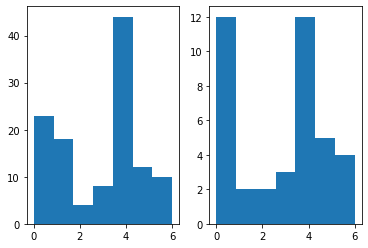

In [10]:
# Actually find labels, and count
train_pred = net.forward(torch.from_numpy(X_train)).data.numpy()
test_pred = net.forward(torch.from_numpy(X_test)).data.numpy()

train_labels = np.argmax(train_pred, axis=1)
test_labels = np.argmax(test_pred, axis=1)

train_success = np.sum(train_labels == y_train_labels) / train_labels.shape[0]
test_success = np.sum(test_labels == y_test_labels) / test_labels.shape[0]

print('Training Success Rate: %8.2f'% (train_success*100.0))
print(' Testing Success Rate: %8.2f'% ( test_success*100.0))

plt.subplot(121)
plt.hist(y_train_labels, 7)
plt.title('Training Data')

plt.subplot(122)
plt.hist(y_test_labels, 7)
plt.title('Test Data')
plt.show()

